In [1]:
import keras
import numpy as np
import pandas as pd
import cv2
import csv
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import Sequential, Model,load_model
from keras.layers import Dense, Activation, Flatten, Dropout, Conv2D, MaxPooling2D, AveragePooling2D, concatenate, Input, Lambda, Cropping2D
from keras import utils
from keras.callbacks import Callback, LambdaCallback, EarlyStopping, ModelCheckpoint, TensorBoard, LearningRateScheduler, ReduceLROnPlateau
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras import backend as K
from keras.preprocessing import image
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

Using TensorFlow backend.


In [2]:
def logger(epoch, logs):
    if epoch %2== 0:
        print(epoch, logs)
logging_callback = LambdaCallback(on_epoch_end=logger)

# get list of images to use
data_file_paths = ['data_sample/', 'data2/', 'data_recovery/', 'data_reverse/']
samples = []
for folder in data_file_paths:
    temp = []
    with open(folder + 'driving_log.csv') as f:
        reader = csv.reader(f)
        for line in reader:
            lineout = [a.split('/')[len(a.split('/'))-1] for a in line]
            lineout2 = [(folder + 'IMG/' + x) if x.endswith('.jpg') else x for x in lineout]
            temp.append(lineout2)
    samples += temp[1:]


def nvidia_model(input_shape):
    inputs = Input(shape=input_shape)
    cropped = Cropping2D(cropping=((70, 25), (0, 0)))(inputs)
    processed = Lambda(lambda x: (x /255. - 0.5))(cropped)

    block1 = Conv2D(24, kernel_size=5,strides=(2,2), activation='relu', padding='same', name='set1_conv1')(processed)
    block1 = BatchNormalization()(block1)
    block2 = Conv2D(36, kernel_size=5,strides=(2,2), activation='relu', padding='same', name='set2_conv1')(block1)
    block2 = BatchNormalization()(block2)
    block3 = Conv2D(48, kernel_size=5,strides=(2,2), activation='relu', padding='same', name='set3_conv1')(block2)
    block3 = BatchNormalization()(block3)
    block4 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name='set4_conv1')(block3)
    block4 = BatchNormalization()(block4)
    block5 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name='set5_conv1')(block4)
    block5 = BatchNormalization()(block5)

    flat1 = Flatten()(block5)

    fcblock = Dense(100, activation='relu', name='fc1')(flat1)
    fcblock = Dense(50, activation='relu', name='fc2')(fcblock)
    fcblock = Dense(10, activation='relu' , name='fc3')(fcblock)

    predictions = Dense(1, name='final')(fcblock)
    model = Model(inputs=inputs, outputs=predictions)
    return model

def vgglike(input_shape, ksize=(3,3), dropout=0.25):
    inputs = Input(shape=input_shape)
    cropped = Cropping2D(cropping=((70, 25), (0, 0)))(inputs)
    processed = Lambda(lambda x: (x /255. - 0.5))(cropped)

    block1 = Conv2D(32, kernel_size=ksize, activation='relu', padding='same', name='set1_conv1')(processed)
    block1 = BatchNormalization()(block1)
    block1 = Conv2D(32, kernel_size=ksize, activation='relu', padding='same', name='set1_conv2')(block1)
    block1 = BatchNormalization()(block1)
    block1 = MaxPooling2D(pool_size=(2, 2),strides=(2, 2), name='set1_pool')(block1)

    block2 = Conv2D(64, kernel_size=ksize, activation='relu', padding='same', name='set2_conv1')(block1)
    block2 = BatchNormalization()(block2)
    block2 = Conv2D(64, kernel_size=ksize, activation='relu', padding='same', name='set2_conv2')(block2)
    block2 = BatchNormalization()(block2)
    block2 = Conv2D(64, kernel_size=ksize, activation='relu', padding='same', name='set2_conv3')(block2)
    block2 = BatchNormalization()(block2)
    block2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2),name='set2_pool')(block2)
    output2 = Flatten()(block2)

    fcblock = Dense(1024, activation='relu', name='fc1')(output2)
    fcblock = BatchNormalization()(fcblock)
    fcblock = Dropout(dropout)(fcblock)
    fcblock = Dense(512, activation='relu' , name='fc2')(fcblock)
    fcblock = BatchNormalization()(fcblock)
    fcblock = Dropout(dropout)(fcblock)

    predictions = Dense(1, name='final')(fcblock)
    model = Model(inputs=inputs, outputs=predictions)
    return model



In [3]:
# from https://github.com/keras-team/keras/blob/bc285462ad8ec9b8bc00bd6e09f9bcd9ae3d84a2/examples/cifar10_resnet.py
"""
ResNet v1
[a] Deep Residual Learning for Image Recognition
https://arxiv.org/pdf/1512.03385.pdf
ResNet v2
[b] Identity Mappings in Deep Residual Networks
https://arxiv.org/pdf/1603.05027.pdf
"""

# Training parameters
batch_size = 32
epochs = 200
data_augmentation = True
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1090Ti
#           |      | %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  |  3   | 92.16     | 91.25     | -----     | NA        | 35
# ResNet32  |  5   | 92.46     | 92.49     | -----     | NA        | 50
# ResNet44  |  7   | 92.50     | 92.83     | -----     | NA        | 70
# ResNet56  |  9   | 92.71     | 93.03     | 92.60     | NA        | 90 (100)
# ResNet110 |  18  | 92.65     | 93.39     | 93.03     | 93.63     | 165(180)
# ---------------------------------------------------------------------------
n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# Computed depth from supplied model parameter n
depth = n * 6 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)


# # Input image dimensions.
# input_shape = x_train.shape[1:]

# # Normalize data.
# x_train = x_train.astype('float32') / 255
# x_test = x_test.astype('float32') / 255




def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_block(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder
    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        conv_first (bool): conv-bn-activation (True) or
            activation-bn-conv (False)
    # Returns
        x (tensor): tensor as input to the next layer
    """
    if conv_first:
        x = Conv2D(num_filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same',
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(inputs)
        x = BatchNormalization()(x)
        if activation:
            x = Activation(activation)(x)
        return x
    x = BatchNormalization()(inputs)
    if activation:
        x = Activation('relu')(x)
    x = Conv2D(num_filters,
               kernel_size=kernel_size,
               strides=strides,
               padding='same',
               kernel_initializer='he_normal',
               kernel_regularizer=l2(1e-4))(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]
    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    The number of filters doubles when the feature maps size
    is halved.
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M
    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    inputs = Input(shape=input_shape)
    num_filters = 16
    num_sub_blocks = int((depth - 2) / 6)

    x = resnet_block(inputs=inputs)
    # Instantiate convolutional base (stack of blocks).
    for i in range(3):
        for j in range(num_sub_blocks):
            strides = 1
            is_first_layer_but_not_first_block = j == 0 and i > 0
            if is_first_layer_but_not_first_block:
                strides = 2
            y = resnet_block(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_block(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if is_first_layer_but_not_first_block:
                x = resnet_block(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters = 2 * num_filters

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]
    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    Features maps sizes: 16(input), 64(1st sub_block), 128(2nd), 256(3rd)
    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    inputs = Input(shape=input_shape)
    num_filters_in = 16
    num_filters_out = 64
    filter_multiplier = 4
    num_sub_blocks = int((depth - 2) / 9)

    # v2 performs Conv2D on input w/o BN-ReLU
    x = Conv2D(num_filters_in,
               kernel_size=3,
               padding='same',
               kernel_initializer='he_normal',
               kernel_regularizer=l2(1e-4))(inputs)

    # Instantiate convolutional base (stack of blocks).
    for i in range(3):
        if i > 0:
            filter_multiplier = 2
        num_filters_out = num_filters_in * filter_multiplier

        for j in range(num_sub_blocks):
            strides = 1
            is_first_layer_but_not_first_block = j == 0 and i > 0
            if is_first_layer_but_not_first_block:
                strides = 2
            y = resnet_block(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             conv_first=False)
            y = resnet_block(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_block(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if j == 0:
                x = Conv2D(num_filters_out,
                           kernel_size=1,
                           strides=strides,
                           padding='same',
                           kernel_initializer='he_normal',
                           kernel_regularizer=l2(1e-4))(x)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

def resnet_custom(input_shape, depth, num_classes=1):
    inputs = Input(shape=input_shape)
    cropped = Cropping2D(cropping=((70, 25), (0, 0)))(inputs)
    processed = Lambda(lambda x: (x /255. - 0.5))(cropped) 
    resized = Lambda(lambda x: K.tf.image.resize_images(x, (224, 224)))(processed)
    
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_sub_blocks = int((depth - 2) / 6)

    x = resnet_block(inputs=resized)
    # Instantiate convolutional base (stack of blocks).
    for i in range(3):
        for j in range(num_sub_blocks):
            strides = 1
            is_first_layer_but_not_first_block = j == 0 and i > 0
            if is_first_layer_but_not_first_block:
                strides = 2
            y = resnet_block(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_block(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if is_first_layer_but_not_first_block:
                x = resnet_block(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters = 2 * num_filters

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


# Prepare callbacks for model saving and for learning rate adjustment.
# checkpoint = ModelCheckpoint(filepath=filepath,
#                              monitor='val_acc',
#                              verbose=1,
#                              save_best_only=True)

# lr_scheduler = LearningRateScheduler(lr_schedule)

# lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
#                                cooldown=0,
#                                patience=5,
#                                min_lr=0.5e-6)

# callbacks = [checkpoint, lr_reducer, lr_scheduler]


In [4]:
# using my own data on the nvidia model did fairly well until it ran into the desert-- let's see if we can imporve this
# fist use data with flipped + add in left and right images
data_file_paths = ['data2/', 'data_recovery/', 'data_reverse/']


In [5]:
images = []
steering = []

In [6]:
# normal center cam + augmentation
lines = []
with open(data_file_paths[0] + '/driving_log.csv') as f:
    reader = csv.reader(f)
    for line in reader:
        lineout = [x.replace('/Users/wwymak/simulator_files', '').replace(' ', '') for x in line]
        lines.append(lineout)

images_set1 = []
steering_set1 = []
for line in lines[1:]:
    img_path = line[0]
    image = cv2.imread(data_file_paths[0] + img_path)
    images_set1.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    steering_set1.append(line[3]) 

augmented_img = []
augmented_measurements = []

for img, measurement in zip(images_set1, steering_set1):
    augmented_img.append(img)
    augmented_measurements.append(float(measurement))
    augmented_img.append(np.fliplr(img))
    augmented_measurements.append(float(measurement) * -1.0)
    
images = augmented_img
steering = augmented_measurements

images_set2 = []
steering_set2 = []

for line in lines[1:]:
    left_img_path = line[1]
    right_img_path = line[2]
    steering_angle = float(line[3])
    
    image_left = cv2.imread(data_file_paths[0] + left_img_path)
    image_right = cv2.imread(data_file_paths[0] + right_img_path)
    
    
#     images_set2.append(image_left)
#     steering_set2.append(steering_angle + 0.008 * steering_angle) 
#     images_set2.append(image_right)
#     steering_set2.append(steering_angle - 0.005 * steering_angle) 

    images.append(cv2.cvtColor(image_left, cv2.COLOR_BGR2RGB))
    steering.append(steering_angle + 0.008 * steering_angle) 
    images.append(cv2.cvtColor(image_right, cv2.COLOR_BGR2RGB))
    steering.append(steering_angle - 0.005 * steering_angle) 


In [10]:
data_file_paths = ['data_reverse/']
samples = []
for folder in data_file_paths:
    temp = []
    with open(folder + 'driving_log.csv') as f:
        reader = csv.reader(f)
        for line in reader:
            lineout = [a.split('/')[len(a.split('/'))-1] for a in line]
            lineout2 = [(folder + 'IMG/' + x) if x.endswith('.jpg') else x for x in lineout]
            temp.append(lineout2)
    samples += temp[1:]


In [11]:
images_set2 = []
steering_set2 = []

for line in lines[1:]:
    left_img_path = line[1]
    right_img_path = line[2]
    steering_angle = float(line[3])
    
    image_left = cv2.imread(data_file_paths[0] + left_img_path)
    image_right = cv2.imread(data_file_paths[0] + right_img_path)
    
    
#     images_set2.append(image_left)
#     steering_set2.append(steering_angle + 0.008 * steering_angle) 
#     images_set2.append(image_right)
#     steering_set2.append(steering_angle - 0.005 * steering_angle) 

    images.append(cv2.cvtColor(image_left, cv2.COLOR_BGR2RGB))
    steering.append(steering_angle + 0.008 * steering_angle) 
    images.append(cv2.cvtColor(image_right, cv2.COLOR_BGR2RGB))
    steering.append(steering_angle - 0.005 * steering_angle) 



[['data_reverse/IMG/center_2017_12_11_21_19_06_151.jpg',
  'data_reverse/IMG/left_2017_12_11_21_19_06_151.jpg',
  'data_reverse/IMG/right_2017_12_11_21_19_06_151.jpg',
  '0',
  '0',
  '0',
  '7.957492'],
 ['data_reverse/IMG/center_2017_12_11_21_19_06_222.jpg',
  'data_reverse/IMG/left_2017_12_11_21_19_06_222.jpg',
  'data_reverse/IMG/right_2017_12_11_21_19_06_222.jpg',
  '0',
  '0',
  '0',
  '7.894733'],
 ['data_reverse/IMG/center_2017_12_11_21_19_06_290.jpg',
  'data_reverse/IMG/left_2017_12_11_21_19_06_290.jpg',
  'data_reverse/IMG/right_2017_12_11_21_19_06_290.jpg',
  '0',
  '0',
  '0',
  '7.848'],
 ['data_reverse/IMG/center_2017_12_11_21_19_06_384.jpg',
  'data_reverse/IMG/left_2017_12_11_21_19_06_384.jpg',
  'data_reverse/IMG/right_2017_12_11_21_19_06_384.jpg',
  '0.25',
  '0',
  '0',
  '7.754702'],
 ['data_reverse/IMG/center_2017_12_11_21_19_06_477.jpg',
  'data_reverse/IMG/left_2017_12_11_21_19_06_477.jpg',
  'data_reverse/IMG/right_2017_12_11_21_19_06_477.jpg',
  '0.5000001',
 

In [7]:

X_train = np.array(images)
y_train = np.array(steering)



In [8]:
X_train.shape

(32144, 160, 320, 3)

In [12]:
K.clear_session()
batch_size = 32
epochs = 30
nvidia_model_instance = nvidia_model((160,320,3))
nvidia_model_instance.compile(loss='mse', optimizer='adam')

nvidia_model2_hist = nvidia_model_instance.fit(X_train, y_train, batch_size=batch_size,
                    epochs=epochs,validation_split=0.2,
                      verbose=0,shuffle=True, 
                    callbacks=[logging_callback, ModelCheckpoint('./models/nvidia_model_no_recovery_right0005_left008_steering_cv2fix.h5', save_best_only=True),
                              TensorBoard(log_dir='./logs/nvidia/no_recovery_r005l008' )]
                   )

0 {'val_loss': 0.011238827169436059, 'loss': 0.017968070878166122}
2 {'val_loss': 0.010710655863751447, 'loss': 0.0096641629137715936}
4 {'val_loss': 18.213664360157246, 'loss': 0.0082044956430607375}
6 {'val_loss': 0.0096215623756704029, 'loss': 0.0091983508483812586}
8 {'val_loss': 0.029741040985787344, 'loss': 0.0083896920689416603}
10 {'val_loss': 0.0091377944535006358, 'loss': 0.0098453467299293596}
12 {'val_loss': 0.0099549080719857699, 'loss': 0.0090994886422340396}
14 {'val_loss': 0.012242231898367298, 'loss': 0.0071730175948676988}
16 {'val_loss': 0.011150007736911891, 'loss': 0.0055385390340401087}
18 {'val_loss': 0.012080400117578384, 'loss': 0.0037372690654100264}
20 {'val_loss': 0.011780244129731485, 'loss': 0.0025188040262804916}
22 {'val_loss': 0.011565361552225531, 'loss': 0.002043934612621499}
24 {'val_loss': 0.01108650181374124, 'loss': 0.0015393313906066251}
26 {'val_loss': 0.011267487014743659, 'loss': 0.0015415827390773506}
28 {'val_loss': 0.010814424112803051, 'lo

In [17]:
lines = samples

images_set1 = []
steering_set1 = []
for line in lines[1:]:
    img_path = line[0]
    image = cv2.imread(img_path)
    images_set1.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    steering_set1.append(line[3]) 

augmented_img = []
augmented_measurements = []

for img, measurement in zip(images_set1, steering_set1):
    augmented_img.append(img)
    augmented_measurements.append(float(measurement))
    augmented_img.append(np.fliplr(img))
    augmented_measurements.append(float(measurement) * -1.0)
    
images = augmented_img
steering = augmented_measurements

images_set2 = []
steering_set2 = []

for line in lines[1:]:
    left_img_path = line[1]
    right_img_path = line[2]
    steering_angle = float(line[3])
    
    image_left = cv2.imread(left_img_path)
    image_right = cv2.imread(right_img_path)
    
    
#     images_set2.append(image_left)
#     steering_set2.append(steering_angle + 0.008 * steering_angle) 
#     images_set2.append(image_right)
#     steering_set2.append(steering_angle - 0.005 * steering_angle) 

    images.append(cv2.cvtColor(image_left, cv2.COLOR_BGR2RGB))
    steering.append(steering_angle + 0.005 * steering_angle) 
    images.append(cv2.cvtColor(image_right, cv2.COLOR_BGR2RGB))
    steering.append(steering_angle - 0.008 * steering_angle) 

In [18]:
del X_train 
del y_train

X_train = np.array(images)
y_train = np.array(steering)

In [20]:
batch_size = 32
epochs = 30

nv_hist2 = nvidia_model_instance.fit(X_train, y_train, batch_size=batch_size,
                    epochs=epochs,validation_split=0.2,
                      verbose=0,shuffle=True, 
                    callbacks=[logging_callback, ModelCheckpoint('./models/nvidia_model_no_recovery_right0005_left008_steering_cv2fix_with_reverse.h5', save_best_only=True),
                              TensorBoard(log_dir='./logs/nvidia/no_recovery_r005l008_with_reverse' )]
                   )

0 {'val_loss': 0.051715125255571835, 'loss': 0.069863176809525918}
2 {'val_loss': 0.069269036043071358, 'loss': 0.034434632098441269}
4 {'val_loss': 0.055866596798459886, 'loss': 0.0137152531139488}
6 {'val_loss': 0.055814494834671893, 'loss': 0.004745883999063602}
8 {'val_loss': 0.054096939115173263, 'loss': 0.0026476582809804622}
10 {'val_loss': 0.060659043913567079, 'loss': 0.0053571813154706044}
12 {'val_loss': 0.05780523407571974, 'loss': 0.0040181830902204889}
14 {'val_loss': 0.054869987587169829, 'loss': 0.0023707515421382925}
16 {'val_loss': 0.054799429458414636, 'loss': 0.0020586468765205336}
18 {'val_loss': 0.053172502889793125, 'loss': 0.0012608227439222205}
20 {'val_loss': 0.056298544336041582, 'loss': 0.0015363975896143689}
22 {'val_loss': 0.055500485439093354, 'loss': 0.0018907837330520273}
24 {'val_loss': 0.05515048116821257, 'loss': 0.0022718157637139883}
26 {'val_loss': 0.052324768677454496, 'loss': 0.0019344658728119237}
28 {'val_loss': 0.053996958199155488, 'loss': 0

In [13]:
train_samples, validation_samples = train_test_split(samples, test_size=0.2)
print(train_samples[:3])

def generator(samples, batch_size=8):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []

            for batch_sample in batch_samples:
                center_image = cv2.imread(batch_sample[0])
                left_image = cv2.imread(batch_sample[1])
                right_image = cv2.imread(batch_sample[2])

                center_angle = float(batch_sample[3])

                images.append(center_image)
                angles.append(center_angle)

                images.append(left_image)
                angles.append(center_angle * (1 + np.random.normal(0.01, 0.005)))

                images.append(right_image)
                angles.append(center_angle * (1 - np.random.normal(0.01, 0.005)))

                images.append(np.fliplr(center_image))
                angles.append(float(center_angle) * - 1.0)

            X_train = np.array(images)
            y_train = np.array(angles)
            yield X_train, y_train


[['data_reverse/IMG/center_2017_12_11_21_22_51_245.jpg', 'data_reverse/IMG/left_2017_12_11_21_22_51_245.jpg', 'data_reverse/IMG/right_2017_12_11_21_22_51_245.jpg', '0', '0', '0', '16.52603'], ['data_reverse/IMG/center_2017_12_11_21_22_05_830.jpg', 'data_reverse/IMG/left_2017_12_11_21_22_05_830.jpg', 'data_reverse/IMG/right_2017_12_11_21_22_05_830.jpg', '1', '0', '0', '17.05604'], ['data_reverse/IMG/center_2017_12_11_21_20_24_500.jpg', 'data_reverse/IMG/left_2017_12_11_21_20_24_500.jpg', 'data_reverse/IMG/right_2017_12_11_21_20_24_500.jpg', '0', '0.1764819', '0', '29.97364']]


In [ ]:
train_generator = generator(train_samples, batch_size=8)
validation_generator = generator(validation_samples, batch_size=8)

model = nvidia_model((160, 320, 3))

model.compile(loss='mse', optimizer='adam')
model.fit_generator(train_generator, steps_per_epoch=len(train_samples), validation_data=validation_generator,
            validation_steps=len(validation_samples), epochs=epochs, shuffle=True,
                   callbacks=[logging_callback, ModelCheckpoint('./models/nvidia_alldata.h5', save_best_only=True),TensorBoard(log_dir='./logs/nvidia/alldata' )])


In [ ]:
model = load_model('./nvidia_generator5.h5')

In [2]:
im = cv2.imread('./../../udacity-self-driving-car-misc/behavioural_clongin_trainfiles/simulator_files/IMG/center_2017_12_03_19_30_05_412.jpg')

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
imleft = cv2.imread('./../../udacity-self-driving-car-misc/behavioural_clongin_trainfiles/simulator_files/IMG/left_2017_12_03_19_30_05_412.jpg')
imright = cv2.imread('./../../udacity-self-driving-car-misc/behavioural_clongin_trainfiles/simulator_files/IMG/right_2017_12_03_19_30_05_412.jpg')



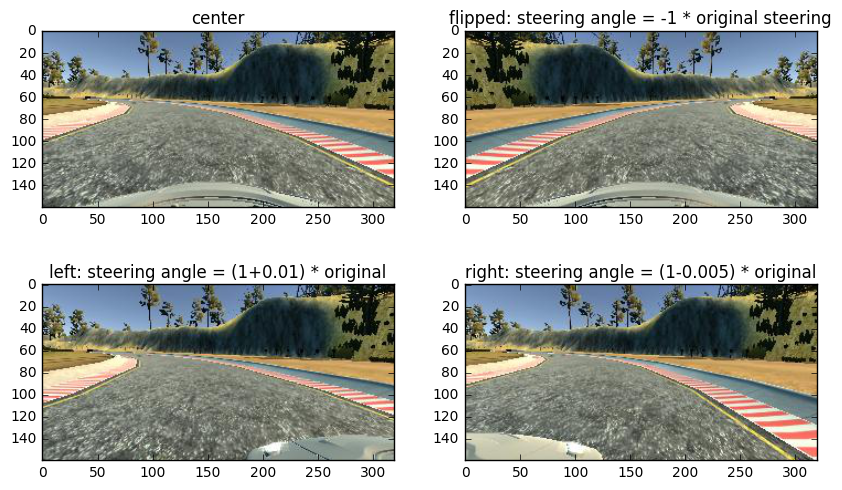

In [8]:

plt.figure(figsize=(10,6))
ax = plt.subplot(2,2,1)
ax.set_title('center')
ax.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
ax2 = plt.subplot(2,2,3)
ax2.set_title('left: steering angle = (1+0.01) * original')
ax2.imshow(cv2.cvtColor(imleft, cv2.COLOR_BGR2RGB))
ax3 = plt.subplot(2,2,4)
ax3.set_title('right: steering angle = (1-0.005) * original')
ax3.imshow(cv2.cvtColor(imright, cv2.COLOR_BGR2RGB))
ax4 = plt.subplot(2,2,2)
ax4.set_title('flipped: steering angle = -1 * original steering')
ax4.imshow(cv2.cvtColor(np.fliplr(im), cv2.COLOR_BGR2RGB))


In [9]:
plt.savefig('./examples/image_augmentation.jpg')